# Precomputed Reactivity for a Control Rod Ejection

## Helper Functions

In [7]:
import xml.etree.ElementTree as ET
from xml.dom import minidom

class Precursor:
    def __init__(self, decay_constant, beta):
        self.decay_constant = decay_constant
        self.beta = beta
        
class Precomp:
    def __init__(self, time, power, rho, concentrations):
        self.time = time
        self.power = power
        self.rho  = rho
        self.concentrations = concentrations
        
class Params:
    def __init__(self, time, rho_imp, lambda_h, gen_time,
                 pow_norm, beta_sum, theta, gamma_d, eta,
                 interpolated):
        self.time = time
        self.rho_imp = rho_imp
        self.lambda_h = lambda_h
        self.gen_time = gen_time
        self.pow_norm = pow_norm
        self.beta_sum = beta_sum
        self.theta = theta
        self.gamma_d = gamma_d
        self.eta = eta
        self.interpolated = interpolated

def write_input_xml(precomp, params, precursors):
    parareal = ET.Element("parareal", 
                          outpath="examples/epke_output.xml", 
                          max_iterations=str(1), 
                          n_fine_per_coarse=str(1))
    
    # epke precomputed values (initial conditions)
    epke_output = ET.SubElement(parareal,"epke_output", n_steps=str(len(precomp.time)))
    ET.SubElement(epke_output, "time").text = ' '.join(map(str,precomp.time))
    ET.SubElement(epke_output, "power").text = ' '.join(map(str,precomp.power))
    ET.SubElement(epke_output, "rho").text = ' '.join(map(str,precomp.rho))
    concentrations_element = ET.SubElement(epke_output, "concentrations")
    
    # epke parameters
    epke_input = ET.SubElement(parareal,"epke_input", 
                               n_steps=str(len(params.time)), 
                               theta=str(params.theta), 
                               gamma_d=str(params.gamma_d),
                               eta=str(params.eta), 
                               interpolated=str(params.interpolated).lower())
    
    ET.SubElement(epke_input, "time").text = ' '.join(map(str, params.time))
    ET.SubElement(epke_input, "rho_imp").text = ' '.join(map(str, params.rho_imp))
    
    if (params.gen_time is not None):
        ET.SubElement(epke_input, "gen_time").text = ' '.join(map(str, params.gen_time))
    else:
        ET.SubElement(epke_input, "gen_time", value="1.58e-5")
    
    if (params.pow_norm is not None):
        ET.SubElement(epke_input, "pow_norm").text = ' '.join(map(str, params.pow_norm))
    else:
        ET.SubElement(epke_input, "pow_norm", value="1.0")
    
    ET.SubElement(epke_input, "beta_eff", value=str(params.beta_sum))
    ET.SubElement(epke_input, "lambda_h").text = ' '.join(map(str,params.lambda_h))
    
    precursors_element = ET.SubElement(epke_input, "precursors")
    for k, precursor in enumerate(precursors):
        precursor_element = ET.SubElement(precursors_element, "precursor", k=str(k))
        ET.SubElement(precursor_element, "decay_constant", value=str(precursor.decay_constant))
        ET.SubElement(precursor_element, "delayed_fraction", value=str(precursor.beta))
        ET.SubElement(concentrations_element, "concentration", 
                      k=str(k)).text = ' '.join(map(str, precomp.concentrations[k])) 
    
    # pretty print and write to xml
    xmlstr = minidom.parseString(ET.tostring(parareal)).toprettyxml(indent=" ")
    
    with open("epke_input.xml", "w") as f:
        f.write(xmlstr)

## Write Input Data to XML File

In [8]:
import numpy as np

t_load, rho_imp_load, gen_time_load, pow_norm_load, \
relative_power_load = np.loadtxt("cr_ejection_parcs.txt",
                                 unpack=True,skiprows=2)

t_step = 100
t = np.linspace(0,max(t_load),int(max(t_load))*t_step+1)

rho_imp_parcs = np.interp(t,t_load,rho_imp_load)

rho_imp = np.copy(rho_imp_parcs)
rho_max = max(rho_imp_parcs)
for i in range(len(rho_imp)):
    if (rho_imp[i] >= rho_max):
        break
rho_imp[i:] = rho_max

gen_time = np.interp(t,t_load,gen_time_load)
pow_norm = np.interp(t,t_load,pow_norm_load)
relative_power = np.interp(t,t_load,relative_power_load)


t = t[:6*t_step]
rho_imp = rho_imp[:6*t_step]
rho_imp_parcs = rho_imp_parcs[:6*t_step]
gen_time = gen_time[:6*t_step]
pow_norm = pow_norm[:6*t_step]
relative_power = relative_power[:6*t_step]

precursors = [Precursor(0.0128, 0.02584e-2), Precursor(0.0318, 0.152e-2),
              Precursor(0.119, 0.13908e-2), Precursor(0.3181, 0.30704e-2),
              Precursor(1.4027, 0.1102e-2), Precursor(3.9286, 0.02584e-2)]
beta_sum = sum([p.beta for p in precursors])
beta_eff = beta_sum * np.ones(len(t))
lambduh_h = 0.29 * np.ones(len(t))
rho_imp *= beta_sum
gamma_d = -1.22 * beta_sum
theta = 0.5
eta = 1.0
interpolated = True

params = Params(t, rho_imp, lambduh_h, gen_time, 
                pow_norm, beta_sum, theta, gamma_d, 
                eta, interpolated)

# generate the initial conditions
precomp_time = [0.0]
precomp_power = [1e-6]
precomp_rho = [rho_imp[0]]
precomp_concentrations = []

for j, precursor in enumerate(precursors):
    initial_concentration = precursor.beta*precomp_power[0]/precursor.decay_constant
    precomp_concentrations.append([initial_concentration])

precomp = Precomp(precomp_time, precomp_power, 
                  precomp_rho, precomp_concentrations)
    
# write to xml
write_input_xml(precomp, params, precursors)

## Run the EPKE Executable

In [9]:
import subprocess

args = "./epke-run examples/epke_input.xml".split()
popen = subprocess.Popen(args, cwd="..", stdout=subprocess.PIPE)
popen.wait()
while True:
    line = popen.stdout.readline()
    if not line:
        break
    print(line.rstrip().decode('utf-8'))

Reading input file: examples/epke_input.xml
Solving...
Completed solve.
Writing output to examples/epke_output.xml


## Read the XML Output

In [10]:
tree = ET.parse('epke_output.xml')
root = tree.getroot()
epke_output = root.find('epke_output')
epke_params = root.find('epke_input')

for child in epke_output:
    if (child.tag == 'time'):
        time_out = np.fromstring(child.text, dtype=float, sep=' ')
    if (child.tag == 'power'):
        p_out = np.fromstring(child.text, dtype=float, sep=' ')
    if (child.tag == 'rho'):
        rho_out = np.fromstring(child.text, dtype=float, sep=' ')
        
rho_imp_out = np.fromstring(epke_params.find('rho_imp').text, dtype=float, sep=' ')

## Plot the Reactivity

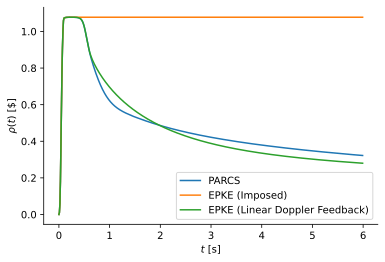

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

ax = plt.subplot(111)
ax.plot(t,rho_imp_parcs,label='PARCS')
ax.plot(time_out,rho_imp_out/beta_sum,label='EPKE (Imposed)')
ax.plot(time_out,rho_out/beta_sum,label='EPKE (Linear Doppler Feedback)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('$t$ [s]')
plt.ylabel('$\\rho(t)$ [\$]')
plt.legend()
plt.show()

## Plot the Power

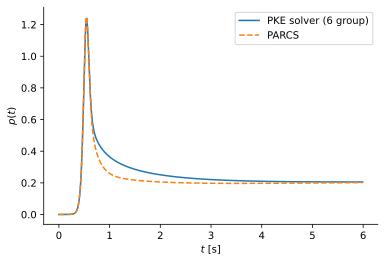

In [12]:
ax = plt.subplot(111)
ax.plot(time_out,p_out,label='PKE solver (6 group)')
ax.plot(t,relative_power,label='PARCS',linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('$t$ [s]')
plt.ylabel('$p(t)$')
plt.legend()
plt.savefig('power_doppler.pgf',bbox_inches='tight',transparent=True)
plt.show()